# Bayesian Workflow

#### Taken from [Incremental Development of PyMC Models - Allen Downey](https://odsc.medium.com/incremental-development-of-pymc-models-cb2a6a6b8c0b)
## 1. Initial data
## 2. Prior Distribution
## 3. Model
## 4. Prior Predictive Distribution
## 5. Inference
## 6. Posterior Predictive Distribution
## 7. The Predictive Framework
## 8. Summary of Modeling Code
## 9. Workflow Notes
## 10. Workflow from Book


In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import plotnine
from plotnine import *
import arviz as az
import pymc3 as pm

In [2]:
plotnine.options.current_theme=theme_bw()
plotnine.options.figure_size=(4, 4)

pd.set_option('display.max_columns', 100)

source_cats = ["orig_data", "prior_pred", "post_pred"]
source_type = CategoricalDtype(source_cats, ordered=True) 

# 1. Initial Data

In [3]:
mu = 2.4
n_samples = 1000
sample_poisson = pm.Poisson.dist(mu).random(size=n_samples)
sample_poisson_df = pd.DataFrame(sample_poisson, columns=['goals']).assign(source='orig_data')
sample_poisson_df.head(3)

,goals,source
0,4,orig_data
1,2,orig_data
2,3,orig_data


In [4]:
sample_poisson_df.describe()

,goals
count,1000.000000
mean,2.301000
std,1.526017
min,0.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,9.000000


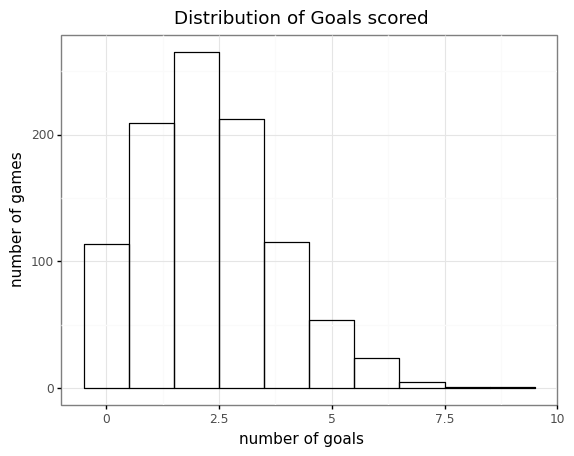

In [5]:
binwidth = 1
p = (ggplot(sample_poisson_df, aes('goals')) +
     geom_histogram(binwidth=binwidth, fill='none', color='black') +
     labs(title='Distribution of Goals scored') +
     xlab('number of goals') +
     ylab('number of games')
    )
p.draw();

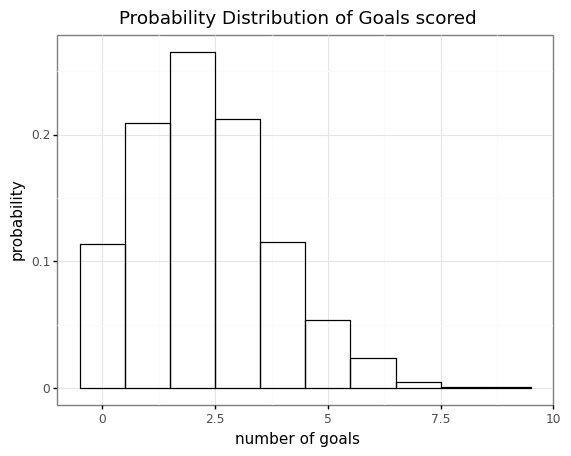

In [6]:
p = (ggplot(sample_poisson_df, aes('goals', y=after_stat('width*density'))) +
     geom_histogram(binwidth=binwidth, fill='none', color='black') +
     labs(title='Probability Distribution of Goals scored') +
     xlab('number of goals') +
     ylab('probability')
    )
p.draw();

# 2. The Prior Distribution

In [7]:
alpha = 4.6
beta = 1.9
prior_mu = pm.Gamma.dist(alpha, beta).random(size=n_samples)
prior_mu_df = pd.DataFrame(prior_mu, columns=['prior_mu'])
prior_mu_df

,prior_mu
0,1.347276
1,1.793901
2,1.067196
3,1.051858
4,1.716140
...,...
995,2.473998
996,0.586915
997,1.174779
998,1.814735


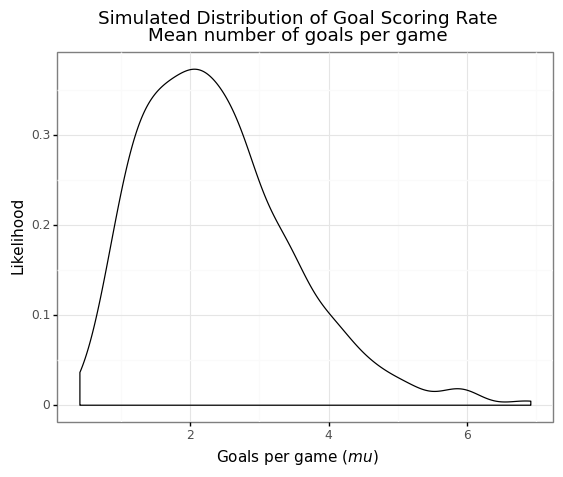

In [8]:
p = (ggplot(prior_mu_df, aes('prior_mu')) +
     geom_density() +
     scale_x_continuous() +
     labs(title='Simulated Distribution of Goal Scoring Rate\nMean number of goals per game') +
     xlab('Goals per game ($mu$)') +
     ylab('Likelihood')
    )
p.draw();

# 3. Build a Model

In [9]:
# alpha = 4.6
# beta = 1.9
with pm.Model() as model1:
    mu = pm.Gamma('mu', alpha, beta)
    goals = pm.Poisson('goals', mu)

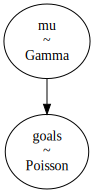

In [10]:
pm.model_to_graphviz(model1)

# 4. The Prior Predictive Distribution

In [11]:
with model1:
    prior_pred = pm.sample_prior_predictive(n_samples)
prior_pred_df = pd.DataFrame(prior_pred).assign(source='prior_pred')
prior_pred_df.head(3)

,goals,mu,mu_log__,source
0,2,1.567591,0.449540,prior_pred
1,5,1.846793,0.613451,prior_pred
2,2,1.623239,0.484423,prior_pred


In [12]:
prior_pred_df.describe()

,goals,mu,mu_log__
count,1000.000000,1000.000000,1000.000000
mean,2.446000,2.427195,0.779272
std,1.882718,1.105753,0.481162
min,0.000000,0.195462,-1.632390
25%,1.000000,1.639711,0.494520
50%,2.000000,2.258449,0.814678
75%,3.000000,3.079142,1.124651
max,11.000000,8.823815,2.177454


In [13]:
# p = (ggplot(prior_pred_df, aes('goals')) +
#      geom_histogram(binwidth=binwidth, fill='none', color='black') +
#      labs(title='Prior Predicted Distribution of Goals scored') +
#      xlab('number of goals/game') +
#      ylab('number of games')
#     )
# p.draw();

In [14]:
# p = (ggplot(prior_pred_df, aes('goals', y=after_stat('width*density'))) +
#      geom_histogram(binwidth=binwidth, fill='none', color='black') +
#      labs(title='Prior Predicted Probability Distribution of Goals scored') +
#      xlab('number of goals/game') +
#      ylab('probability')
#     )
# p.draw();

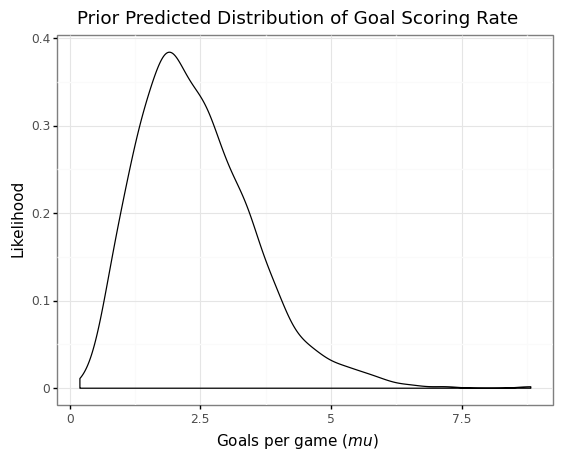

In [15]:
p = (ggplot(prior_pred_df, aes('mu')) +
     geom_density() +
     scale_x_continuous() +
     labs(title='Prior Predicted Distribution of Goal Scoring Rate') +
     xlab('Goals per game ($mu$)') +
     ylab('Likelihood')
    )
p.draw();

In [16]:
df1 = pd.concat([sample_poisson_df, prior_pred_df], axis=0)
df1['source'] = df1['source'].astype(source_type).cat.remove_unused_categories()
df1.head(3)

,goals,source,mu,mu_log__
0,4,orig_data,NaN,NaN
1,2,orig_data,NaN,NaN
2,3,orig_data,NaN,NaN


In [17]:
df1.groupby('source')['goals'].describe().T #[['source', 'goals', 'mu']].describe()

source,orig_data,prior_pred
count,1000.000000,1000.000000
mean,2.301000,2.446000
std,1.526017,1.882718
min,0.000000,0.000000
25%,1.000000,1.000000
50%,2.000000,2.000000
75%,3.000000,3.000000
max,9.000000,11.000000


In [18]:
# p = (ggplot(df1, aes(x='goals', y=after_stat('count'), fill='source')) +
#      geom_histogram(binwidth=binwidth, alpha=0.4, color='black', position='identity') +
#      labs(title='Distribution of Goals scored - prior pred. and orig. data') +
#      xlab('number of goals/game') +
#      ylab('number of games')
#     )
# p.draw();

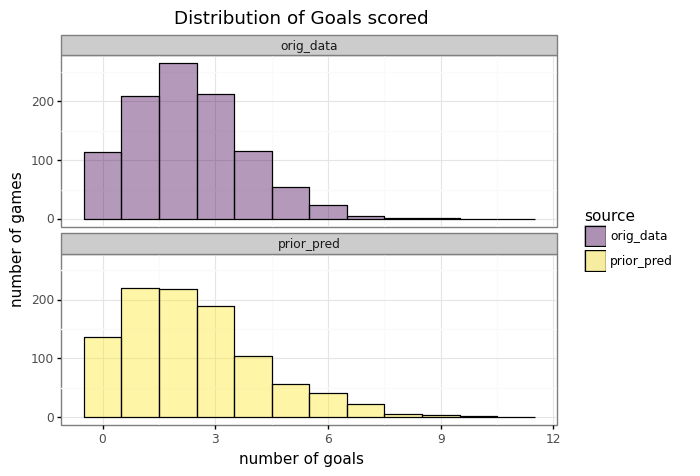

In [19]:
p = (ggplot(df1, aes(x='goals', y=after_stat('count'), fill='source')) +
     geom_histogram(binwidth=binwidth, alpha=0.4, color='black', position='identity') +
     labs(title='Distribution of Goals scored') +
     facet_wrap('source', ncol=1) + 
     xlab('number of goals') +
     ylab('number of games')
    )
p.draw();

+ The prior predictive histogram (blue) is wider than the the original histogram of the data.
+ The 2 plots above show the same thing - once with the plots superimposed and once with the plots separated
+ Th eplots show the spread of the prior predicted data as being larger than the spread of the original data.
+ The `describe` function also shows the standard deviation of the prior predicted data as being larger than that of the original data. 2 reasons:
    + The uncertainty in mu (the distribution of potential mean values of the poisson distribution) ie the distribution being plugged into the Poisson distribution
    + The uncertainty of number of goals scored for each mu ie the poisson distributed uncertainty associated with each mu in the mu distribution

# 5. Inference

In [20]:
# Used to generate prior predictive samples
# with pm.Model() as model1:
#     mu = pm.Gamma('mu', alpha, beta)
#     goals = pm.Poisson('goals', mu)
#     priorp_trace = pm.sample_prior_predictive(n_samples)

# To estimate mu - the posterior
with pm.Model() as model1:
    mu = pm.Gamma('mu', alpha, beta)
    # Changed to include observed
    goals = pm.Poisson('goals', mu, observed=4)
    # Changed to sample from sample_prior_predictive
    # Return an xarray object with the data - makes data accessible to arviz diagnosis plots and functions
    # post_trace = pm.sample(1000, return_inferencedata=True)
    
    trace = pm.sample(1000, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [21]:
trace

<MultiTrace: 4 chains, 1000 iterations, 2 variables>

In [22]:
with model1:
    trace_infobj1 = az.from_pymc3(trace=trace)
trace_infobj1

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [23]:
with model1:
    trace_infobj2 = az.from_pymc3(trace=trace, prior=prior_pred)
trace_infobj2

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

In [24]:
# trace.stat_names #get_sampler_stats()

In [25]:
posterior_df = trace_infobj2.posterior['mu'].to_dataframe().reset_index()
posterior_df.head()

,chain,draw,mu
0,0,0,3.566854
1,0,1,2.475628
2,0,2,1.884928
3,0,3,2.046170
4,0,4,1.961591


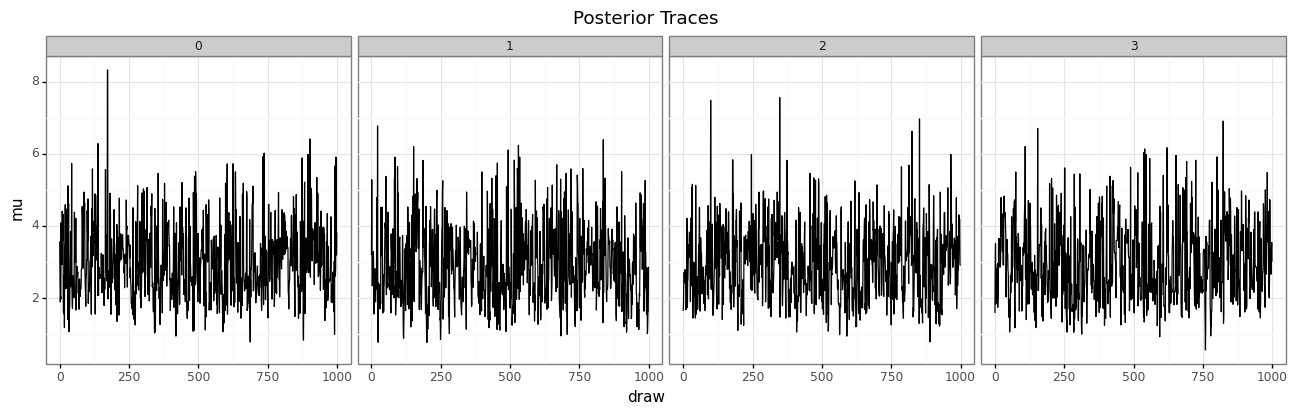

In [26]:
p = (ggplot(posterior_df, aes(x='draw', y='mu')) +
     geom_line() +
     facet_wrap('chain', nrow=1) +
     theme(figure_size=(16,4)) +
     labs(title="Posterior Traces")
    )
p.draw();

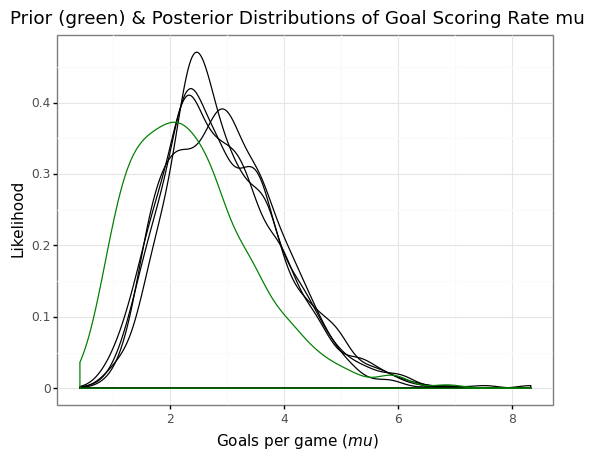

In [27]:
p = (ggplot(posterior_df) +
     geom_density(aes('mu', group='chain'), color='black') +
     geom_density(prior_mu_df, aes('prior_mu'), color='green') +
     scale_x_continuous() + 
     labs(title='Prior (green) & Posterior Distributions of Goal Scoring Rate mu') +
     xlab('Goals per game ($mu$)') +
     ylab('Likelihood')
    )
p.draw();

+ The 4 traces are posterior distributions - the mu which is modified from the prior mu based on the observed data

# 6. Posterior Predictive Distribution

In [28]:
with model1:
    post_pred = pm.sample_posterior_predictive(trace)

In [29]:
with model1:
    # trace_infobj = az.from_pymc3(trace=trace)
    trace_infobj3 = az.from_pymc3(trace=trace, prior=prior_pred, posterior_predictive=post_pred)
trace_infobj3

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

In [30]:
post_pred_df = pd.DataFrame(post_pred).assign(source='post_pred')
post_pred_df.head(3)

,goals,source
0,5,post_pred
1,3,post_pred
2,4,post_pred


In [31]:
df2 = pd.concat([df1, post_pred_df], axis=0)
df2['source'] = df2['source'].astype(source_type)
df2.head(3)

,goals,source,mu,mu_log__
0,4,orig_data,NaN,NaN
1,2,orig_data,NaN,NaN
2,3,orig_data,NaN,NaN


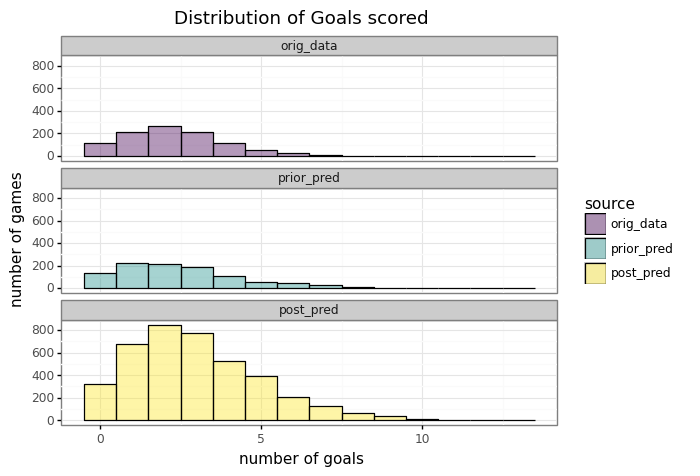

In [32]:
p = (ggplot(df2, aes(x='goals', y=after_stat('count'), fill='source')) +
     geom_histogram(binwidth=binwidth, alpha=0.4, color='black', position='identity') +
     labs(title='Distribution of Goals scored') +
     facet_wrap('source', ncol=1) + 
     xlab('number of goals') +
     ylab('number of games')
    )
p.draw();

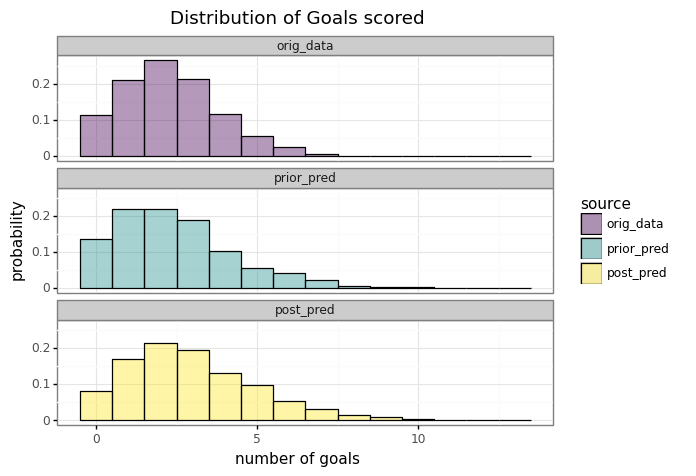

In [33]:
p = (ggplot(df2, aes(x='goals', y=after_stat('density'), fill='source')) +
     geom_histogram(binwidth=binwidth, alpha=0.4, color='black', position='identity') +
     labs(title='Distribution of Goals scored') +
     facet_wrap('source', ncol=1) + 
     xlab('number of goals') +
     ylab('probability')
    )
p.draw();

# 7. The Predictive Framework

![alt text](img/the-predictive-framework.png "Title")

+ Review the original data
+ Define a prior distribution for a parameter that can be used in a generative function to generate similar data to the original data. So this is actually embedded into defining the model.
+ **sample_prior_predictive** Sample from the prior predictive distributions. This will return prior distributions of the priors and the prior predicted data. Check that these distributions have adequate coverage to describe the original data.
+ **sample** Use the original data to update the model. This returns traces of the posterior distribution. The posterior distribution captures the junction between the priors, model and observed data. It only concerns the original data. It does not allow us to make predictions about future/unseen data. I think this is something like a [tolerance interval](https://en.wikipedia.org/wiki/Tolerance_interval) - maybe?
+ **sample_posterior_predictive** This accepts the trace from sample, and produces distributions that can be used to predict future/unseen data. I think this is something like a [prediction interval](https://en.wikipedia.org/wiki/Prediction_interval#Contrast_with_other_intervals)

# 8. Summary of Modeling Code

In [34]:
# Model Definition
obs = [4, 4]
alpha = 4.6
beta = 1.9
with pm.Model() as model1:
    mu = pm.Gamma('mu', alpha, beta)
    goals = pm.Poisson('goals', mu)

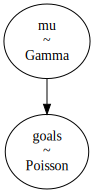

In [35]:
# Check the Model Defn.
pm.model_to_graphviz(model1)

In [36]:
# Prior predictive Sampling
with model1:
    prior_pred = pm.sample_prior_predictive(n_samples)
    trace_infobj = az.from_dict(prior_predictive=prior_pred)
trace_infobj

Inference data with groups:
	> prior_predictive

In [37]:
# with model1:
#     trace_infobj = az.from_dict(prior_predictive=prior_pred)
# trace_infobj

**Understand Your Assumptions** - Chapter 2
+ Run diagnosis on the prior predictive distributions. This seems like it is a bit manual, and relies on having an intuition for what reasonable prior parameters and data distributions should look like. It does not seem to involve arviz.

In [38]:
# Run the inference engine
# This fits the data/model

# Used to generate prior predictive samples
# with pm.Model() as model1:
#     mu = pm.Gamma('mu', alpha, beta)
#     goals = pm.Poisson('goals', mu)
#     priorp_trace = pm.sample_prior_predictive(n_samples)

# To estimate mu - the posterior
with pm.Model() as model1:
    mu = pm.Gamma('mu', alpha, beta)
    # Changed to include observed
    goals = pm.Poisson('goals', mu, observed=obs)
    # Changed to sample from sample_prior_predictive
    # Return an xarray object with the data - makes data accessible to arviz diagnosis plots and functions
    # post_trace = pm.sample(1000, return_inferencedata=True)
    
    trace = pm.sample(1000, return_inferencedata=False)
    trace_infobj.extend(az.from_pymc3(trace=trace))
trace_infobj

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Inference data with groups:
	> prior_predictive
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

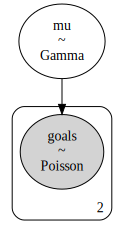

In [39]:
# Check the Model Defn. after the data is incorporated
pm.model_to_graphviz(model1)

In [40]:
# Convert the trace and the prior into an arviz object for diagnosis
# with model1:
    # OR to update with prior at same time
    # trace_infobj = az.from_pymc3(trace=trace, prior=prior_predictive)
    
    # OR if prior is already in object
    # trace_infobj.extend(az.from_pymc3(trace=trace))
    
    # OR in a 2 stager
    # trace_infobj = az.from_pymc3(trace=trace)
    # trace_infobj.add_groups(prior_predictive=prior_pred)
# trace_infobj

**Understand your Predictions** - Chapter 2
+ Bayesian p values
+ Comparison of original data with predicted distributions from `sample`

In [41]:
# Sample posterior predictive data
# This uses the fitted model to make predictions about unseen/future data
with model1:
    post_pred = pm.sample_posterior_predictive(trace)
    trace_infobj.add_groups(posterior_predictive=post_pred)
trace_infobj

/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/data/base.py:169: UserWarning: More chains (4000) than draws (2). Passed array should have shape (chains, draws, *shape)


Inference data with groups:
	> prior_predictive
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> posterior_predictive

In [42]:
# Update the arviz inference object with the posterior predictive data - use for further diagnosis
# with model1:
#     trace_infobj.add_groups(posterior_predictive=post_pred)
# trace_infobj

**Understand your Predictions** - Chapter 2
+ Bayesian p values
+ Comparison of original data with predicted distributions from `sample_posterior_predictive`
+ Do not understand these yet - and seems to be quite a bit of manipulation to line up the plots
    + `az.summary(kind='stats')`
    + `az.plot_dist(pred_dist)`
    + `az.plot_bpv(idata, kind="p_value")`
    + `az.plot_bpv(idata, kind="u_value")`
    + `az.plot_bpv(idata, kind="t_stat", t_stat="mean")`
    + `az.plot_bpv(idata, kind="t_stat", t_stat="std")`

**Diagnose Numerical Inference** - Chapter 2

    + `az.ess(chains)`
    + `az.rhat(chains)`
    + `az.mcse(chains)`
    + `az.summary(chains, kind="diagnostics")`
    + `az.plot_trace(chains)`
    + `az.plot_autocorr(chains, combined=True, figsize=(a, b))`
    + `az.plot_rank(chains, kind="bars", ax=axes)`
    + `az.plot_rank(chains, kind="vlines", figsize=(a, b))`
    + `az.plot_trace(idata, kind="rank_vlines")`
    + `az.plot_pair(idata, divergences=True)`

# Workflow Notes
+ `pm.sample_prior_predictive` returns a dictionary
+ `pm.sample` returns a multi-trace object (or can return an arviz inference object)
+ `pm.sample_posterior_predictive` returns a dictionary
+ Working with `arviz`
    + `arviz` is used for diagnostics, and should make getting plot and summary stats easier.
    + The pymc3 `sample` method can return an arviz object (an xarray frame == 3d dataframe), but by default returns a trace object
    + However, it seems an arviz object **cannot** be passed into `sample_posterior_predictive`. Instead this requires a trace object.
    + But a trace can be converted to an arviz object using `az.from_pymc3(trace=trace)`. This should be done within the model context -ie `with model:`
    + To make an extended arviz object containing the prior predictive data use `az.from_pymc3(trace=trace, prior=prior_pred)`
    + To make an extended arviz object containing the prior predictive data and the post predictive data use `az.from_pymc3(trace=trace, prior=prior_pred, posterior_predictive=post_pred)`
+ Therefore, it may be useful to explicitly convert to arviz inference objects at the various steps of the analysis
+ Because xarray is built to be compatible with pandas, we can use `arviz.inf_obj.<posterior>.to_dataframe()` to easily get data into a dataframe

![alt text](img/bayesian-workflow/the-predictive-framework.png "Title")

# 10. Workflow from Book
+ "Evaluate prior predictive distribution" - `sample_prior_predictive` to get this.
+ "Fit model to data" - `sample` to do this
+ "Evaluate posterior predictive distribution" - `sample_posterior_predictive` to get this


![alt text](img/bayesian-workflow/bayesian-workflow.png "Title")